# Cat Breed Classifier
Gets a cat image from thecatapi.com and classifies its breed

In [1]:
import os
import requests
from PIL import Image
from io import BytesIO
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
def load_api_key(file_path):
    """Load the API key from a file."""
    try:
        with open(file_path, 'r') as file:
            return file.readline().strip()
    except FileNotFoundError:
        raise Exception("API key file not found.")
    except Exception as e:
        raise Exception(f"An error occurred while reading the API key: {str(e)}")

api_key_path = os.path.expanduser('~/.config/catapi/api_key.txt')
api_key = load_api_key(api_key_path)


In [4]:
breed_mapping = {1: 'Abyssinian', 2: 'Bengal', 3: 'Birman', 4: 'Bombay', 5: 'British Shorthair', 6: 'Egyptian Mau', 7: 'Maine Coon', 8: 'Persian', 9: 'Ragdoll', 10: 'Russian Blue', 11: 'Siamese', 12: 'Sphynx'}
breed_mapping = {k - 1: v for k, v in breed_mapping.items()}

In [5]:
# Load model
model = models.resnet50(pretrained=False)

# Adjust the final layer to match modified model from training
num_ftrs = model.fc.in_features
num_classes = len(breed_mapping)
model.fc = nn.Linear(num_ftrs, num_classes)

# Load the weights
model.load_state_dict(torch.load('cat_breed_classifier_32_300_0.180.pth'))

model.eval();

In [6]:
def prepare_image(image_url):
    """Prepare the image for classification."""
    headers = {'x-api-key': api_key}
    response = requests.get(image_url, headers=headers)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

def fetch_image_url():
    """Fetch a random cat image URL from the API."""
    api_url = 'https://api.thecatapi.com/v1/images/search?size=med&mime_types=jpg&format=json&has_breeds=true&order=RANDOM&page=0&limit=1'
    headers = {'x-api-key': api_key}
    response = requests.get(api_url, headers=headers)
    image_data = response.json()
    if image_data:
        return image_data[0]['url']
    return None

def classify_image(image_url, model, breed_mapping):
    """Classify the image to predict the breed and return the top predictions with their confidence scores."""
    image_tensor = prepare_image(image_url)
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        top_probs, top_idxs = torch.topk(probabilities, 3)

        # Filter predictions above 5% confidence
        valid_predictions = [(breed_mapping[idx.item()], prob.item() * 100) for idx, prob in zip(top_idxs[0], top_probs[0]) if prob.item() > 0.05]
        
    return valid_predictions

def display_image_with_prediction(model, breed_mapping):
    """Fetch an image, classify it and display the image with the top predictions."""
    image_url = fetch_image_url()
    if image_url:
        predictions = classify_image(image_url, model, breed_mapping)

        response = requests.get(image_url)
        image = Image.open(BytesIO(response.content))

        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.axis('off')

        if predictions:
            title_text = '\n'.join([f"{breed} ({conf:.1f}%)" for breed, conf in predictions])
        else:
            title_text = "No confident predictions"

        plt.title(title_text)
        plt.show()
    else:
        print("No image found.")

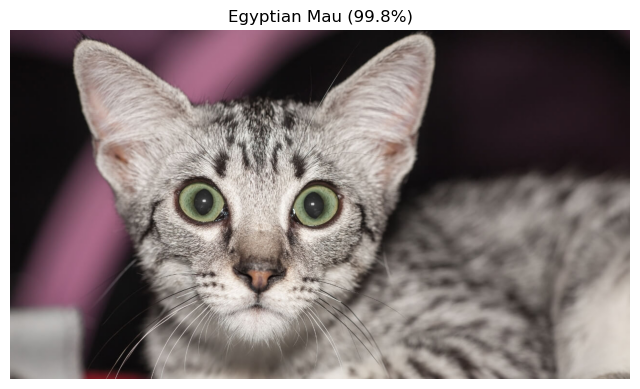

In [16]:
display_image_with_prediction(model, breed_mapping)